In [1]:
import pandas as pd
import numpy as np
import scipy
import scipy.misc
from PIL import Image
import imageio as iio
from pathlib import Path
import string
import glob
import os
from sklearn.cluster import KMeans
from facenet_pytorch import MTCNN, InceptionResnetV1
import torch
from torch.utils.data import DataLoader
from torchvision import datasets
from sklearn.decomposition import PCA
from mpl_toolkits import mplot3d
import matplotlib.pyplot as plt
from sklearn.mixture import GaussianMixture
import itertools
import matplotlib as mpl
from scipy import linalg
from skimage.transform import resize
import skimage.transform as st
from alive_progress import alive_bar
import time
import numpy_indexed as npi

In [2]:
############
###Labels###
#age: from 1 to 116
#gender: 0-male; 1-female
#race: 0-white; 1-black; 2-Asian; 3-Indian; 4-others(like Hispanic, Latino, Middle Eastern)
############

labels = pd.read_csv('./data/labels.csv', header = None)
labels = labels.values
print(labels.shape)
print(labels)

(23705, 3)
[[100   0   0]
 [100   0   0]
 [100   1   0]
 ...
 [  9   1   4]
 [  9   1   4]
 [  9   1   4]]


In [3]:
print("labels of ages: {}".format(np.unique(labels[:, 0])))
print("labels of genders: {}".format(np.unique(labels[:, 1])))
print("labels of races: {}".format(np.unique(labels[:, -1])))

labels of ages: [  1   2   3   4   5   6   7   8   9  10  11  12  13  14  15  16  17  18
  19  20  21  22  23  24  25  26  27  28  29  30  31  32  33  34  35  36
  37  38  39  40  41  42  43  44  45  46  47  48  49  50  51  52  53  54
  55  56  57  58  59  60  61  62  63  64  65  66  67  68  69  70  71  72
  73  74  75  76  77  78  79  80  81  82  83  84  85  86  87  88  89  90
  91  92  93  95  96  99 100 101 103 105 110 111 115 116]
labels of genders: [0 1]
labels of races: [0 1 2 3 4]


In [4]:
# read images from Faces folder
images = list()

filelist = glob.glob('./data/Faces/*.jpg')
for file in sorted(filelist, key=lambda s: int(s.strip(string.ascii_letters + "./"))):
    im = iio.imread(file)
    images.append(im)
images = np.array(images)
print(images.shape)

(23705, 200, 200, 3)


In [5]:
# resize all images from 200*200 to 160*160
im_resize = []
for i in range(images.shape[0]):
    imm_arr = np.array(Image.fromarray(images[i, :, :, :], 'RGB').resize((160, 160)))
    im_resize.append(imm_arr)
im_resize = np.array(im_resize)
print(im_resize.shape)

(23705, 160, 160, 3)


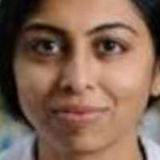

In [6]:
im_1 = im_resize[10001, :, :, :]
Image.fromarray(im_1, 'RGB')

In [7]:
workers = 0
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
print('Running on device: {}'.format(device))

Running on device: cpu


In [8]:
# For a model pretrained on VGGFace2
model = InceptionResnetV1(pretrained='vggface2').eval().to(device)

In [9]:
dataset = np.einsum('klij->kjli', im_resize)
images_tensor = torch.tensor(dataset)
print(images_tensor.shape)
images_sel = images_tensor  # select all images or only a few images
print(images_sel.shape)

torch.Size([23705, 3, 160, 160])
torch.Size([23705, 3, 160, 160])


In [10]:
res = []
def compute():
    global res
    for i in range(images_sel.shape[0]):
        res.append(model(torch.unsqueeze(images_sel[i], 0).float()).detach().numpy())
        yield

In [11]:
with alive_bar(images_sel.shape[0], force_tty=True) as bar:
    for i in compute():
        # time.sleep(.005)
        bar()

|████████████████████████████████████████| 23705/23705 [100%] in 39:31.3 (10.00/s)                                      ▃▅▇ 5353/23705 [23%] in 9:01 (9.9/s, eta: 30:53) 


In [12]:
images_pro = np.squeeze(np.array(res))
print(images_pro.shape)

(23705, 512)


In [13]:
# PCA for dimension reduction
pca = PCA(n_components=120)
pca.fit(images_pro)

PCA(n_components=120)

In [14]:
images_pca = pca.transform(images_pro)
print(images_pca.shape)

(23705, 120)


In [15]:
kmeans = KMeans(n_clusters=10, random_state=0).fit(images_pca)
kmeans_labels = kmeans.labels_

In [16]:
print(kmeans_labels)

[7 2 7 ... 7 6 4]


In [17]:
labels_sel = labels
stacked = np.hstack((labels_sel, kmeans_labels.reshape(np.size(kmeans_labels), 1)))
stacked_sorted = stacked[stacked[:, -1].argsort()]
print(stacked_sorted)

[[36  0  3  0]
 [26  0  2  0]
 [60  0  1  0]
 ...
 [36  0  0  9]
 [56  0  0  9]
 [58  0  1  9]]


In [18]:
def counter(cluster):
    
    # AGE
    # age groups: 1-20; 21-40; 41-60; 61-80; 81-100: >100
    age_counter = np.zeros(6)
    for i in range(cluster.shape[0]):
        if cluster[i, 0] >= 1 and cluster[i, 0] <= 20:
            age_counter[0] += 1
        elif cluster[i, 0] > 20 and cluster[i, 0] <= 40:
            age_counter[1] += 1
        elif cluster[i, 0] > 40 and cluster[i, 0] <= 60:
            age_counter[2] += 1
        elif cluster[i, 0] > 60 and cluster[i, 0] <= 80:
            age_counter[3] += 1
        elif cluster[i, 0] > 80 and cluster[i, 0] <= 100:
            age_counter[4] += 1
        else:
            age_counter[5] += 1
    # age_counter = age_counter / np.sum(counter)
    
    # GENDER
    gender_counter = np.zeros(2)
    for i in range(cluster.shape[0]):
        if cluster[i, 1] == 0:
            gender_counter[0] += 1
        else:
            gender_counter[1] += 1
    
    # RACE
    race_counter = np.zeros(5)
    for i in range(cluster.shape[0]):
        if cluster[i, 2] == 0:
            race_counter[0] += 1
        elif cluster[i, 2] == 1:
            race_counter[1] += 1
        elif cluster[i, 2] == 2:
            race_counter[2] += 1
        elif cluster[i, 2] == 3:
            race_counter[3] += 1
        else:
            race_counter[4] += 1
    
    return age_counter, gender_counter, race_counter

In [19]:
def cluster_division(stacked_labels, num_cluster):
    age_division = np.zeros((num_cluster, 6))
    gender_division = np.zeros((num_cluster, 2))
    race_division = np.zeros((num_cluster, 5))
    for i in range(num_cluster):
        cluster = stacked_labels[stacked_labels[:, -1] == i]
        age_counter, gender_counter, race_counter = counter(cluster)
        age_division[i, :] = age_counter
        gender_division[i, :] = gender_counter
        race_division[i, :] = race_counter
    return age_division, gender_division, race_division

In [20]:
np.set_printoptions(suppress=True)
age_division, gender_division, race_division = cluster_division(stacked_sorted, 10)
print('ROW - which cluster; COLUMN - which group of age/gender/race')
print('age division in different clusters: ')
print(age_division)
print('-------------------------------------------------------------------')
print('gender division in different clusters: ')
print(gender_division)
print('-------------------------------------------------------------------')
print('race division in different clusters: ')
print(race_division)

ROW - which cluster; COLUMN - which group of age/gender/race
age division in different clusters: 
[[ 470. 1405.  383.  126.   21.    0.]
 [ 657. 1108.  360.  153.   55.    1.]
 [ 394.  807.  409.  198.   87.    8.]
 [ 186. 1107.  235.   61.   17.    2.]
 [1278. 1049.  434.  184.   37.    0.]
 [ 225. 1001.  212.   63.   15.    0.]
 [ 217.  622.   92.   23.    7.    0.]
 [ 733. 1901.  994.  473.  140.    6.]
 [ 193.  806.  596.  368.   88.    3.]
 [ 524. 2316.  596.  206.   52.    1.]]
-------------------------------------------------------------------
gender division in different clusters: 
[[1167. 1238.]
 [1348.  986.]
 [1175.  728.]
 [ 732.  876.]
 [1442. 1540.]
 [ 874.  642.]
 [ 392.  569.]
 [2330. 1917.]
 [1418.  636.]
 [1513. 2182.]]
-------------------------------------------------------------------
race division in different clusters: 
[[ 772.  628.  322.  464.  219.]
 [ 795.  704.  309.  348.  178.]
 [ 869.  399.  233.  303.   99.]
 [ 573.  334.  239.  317.  145.]
 [1294.  375. 

In [21]:
# sort1 = stacked_sorted[np.logical_and(stacked_sorted[:, 0] >= 21, stacked_sorted[:, 0] <= 40)]
# sort2 = sort1[np.logical_and(sort1[:, 1] == 0, sort1[:, 2] == 0)]
# sort3 = sort2[sort2[:, -1] == 0]
# print(sort3.shape)

In [40]:
indices = []
for i in range(10):
    indices.append(np.argwhere(stacked[:, -1] == i).T)

In [44]:
# im_resize[im_resize[0, :, :, :] in indices[0]]
cluster_0 = np.squeeze(indices[0], axis = 0)
np.random.shuffle(cluster_0)

In [45]:
cluster_0

array([12555, 17994,  2186, ...,  5965, 16723,  8850])

In [48]:
cl0 = cluster_0[0:10]
for i in range(10):
    im = im_resize[cl0[i], :, :, :]
    imm = Image.fromarray(im, 'RGB')
    imm.show()

In [49]:
cluster_1 = np.squeeze(indices[1], axis = 0)
np.random.shuffle(cluster_1)

In [50]:
cl1 = cluster_1[0:10]
for i in range(10):
    im = im_resize[cl1[i], :, :, :]
    imm = Image.fromarray(im, 'RGB')
    imm.show()

In [52]:
np.savetxt('ForwardedImages.csv', images_pro, delimiter=",") 